# Experimental Results

- metrics RTT, Waiting Time, Success Rate,Cumulative Deadlocks
- try different eps values 

- grid 5x5 fully connected 
- grid 5x5 not fully connected
- random graph

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import math
from math import log, sqrt
import matplotlib.patches as mpatches
from scipy.stats import poisson
import time
np.random.seed(42)
import logging

# Topology Generators

## Uniform Grid

In [2]:
def generate_grid_network(num_nodes, communication_radius, area_size):
        grid_cols = int(math.sqrt(num_nodes))
        grid_rows = int(math.ceil(num_nodes / grid_cols))
        spacing_x = area_size[0] / grid_cols
        spacing_y = area_size[1] / grid_rows
        if communication_radius < min(spacing_x, spacing_y):
            raise ValueError("Increase the communication radius to ensure at least one connection per node.")
        node_positions = {}
        for i in range(num_nodes):
            col = i % grid_cols
            row = i // grid_cols
            node_positions[i] = (spacing_x / 2 + col * spacing_x, spacing_y / 2 + row * spacing_y)
        gateway_position = (area_size[0] / 2, area_size[1] / 2)
        node_positions[num_nodes] = gateway_position
        G = nx.Graph()
        for node, pos in node_positions.items():
            G.add_node(node, pos=pos)
        for i in node_positions:
            for j in node_positions:
                if i != j:
                    distance = np.linalg.norm(np.array(node_positions[i]) - np.array(node_positions[j]))
                    if distance <= communication_radius:
                        G.add_edge(i, j, weight=distance)
        return G, node_positions

## Random Network - At least one path to Gateway per node 

In [3]:
def generate_rand_network(num_nodes, communication_radius, area_size, gateway_node):
        """
        Generates a random network where each node is guaranteed to have at least one path to the gateway.
        """
        node_positions = {}
        G = nx.Graph()

        # Place the gateway node at the center
        gateway_position = (area_size[0] / 2, area_size[1] / 2)
        node_positions[gateway_node] = gateway_position
        G.add_node(gateway_node, pos=gateway_position)

        # Function to check if a new node can connect to the existing network
        def can_connect(x, y, existing_nodes):
            for node in existing_nodes:
                pos = node_positions[node]
                if np.linalg.norm(np.array([x, y]) - np.array(pos)) <= communication_radius:
                    return True
            return False

        # Add nodes one by one, ensuring connectivity
        for i in range(num_nodes):
            while True:
                x = np.random.uniform(0, area_size[0])
                y = np.random.uniform(0, area_size[1])
                if can_connect(x, y, node_positions):
                    node_positions[i] = (x, y)
                    G.add_node(i, pos=(x, y))
                    break

        # Connect nodes within the communication radius
        for i in node_positions:
            for j in node_positions:
                if i != j:
                    distance = np.linalg.norm(np.array(node_positions[i]) - np.array(node_positions[j]))
                    if distance <= communication_radius:
                        G.add_edge(i, j, weight=distance)

        return G, node_positions

# eps- greedy Network Simulator

In [4]:
class GreedyNetwork:
    def __init__(self, graph, node_positions, num_nodes, 
communication_radius, area_size, gateway_node, timeout=5, eps=0.9, lambda_rate = 5.5, vulnerable_time = 36.6*10**(-3)):

        self.num_nodes = num_nodes
        self.communication_radius = communication_radius
        self.area_size = area_size
        self.gateway_node = gateway_node
        self.eps = eps
        self.Timeout = timeout  # both in seconds
        self.G, self.node_positions = graph, node_positions
        self.default_paths = None
        self.avg_metrics = None
        self.cum_metrics = None
        self.exploitation_counter = 0
        self.exploration_counter = 0
        self.num_deadlocks = 0
        self.cum_deadlocks = []
        self.lambda_rate = lambda_rate
        self.vulnerable_time = vulnerable_time
        self.reset()

    def reset(self, graph = None, node_positions = None):
        """
        Resets the simulation to its initial state. Optionally regenerates the network topology.

        :param regenerate_network: Boolean, True if the network topology should be regenerated.
        """
        if (graph is not None) and (node_positions is not None):
            self.G, self.node_positions = graph, node_positions
        self.default_paths = self.__default_shortest_paths__()
        self.cum_metrics = {'cum_round_trip_time': [], 'cum_waiting_time': [], 'cum_success_rate': []}
        self.avg_metrics = {'avg_round_trip_time': [], 'avg_waiting_time': [], 'avg_success_rate': []}
        self.exploitation_counter = 0
        self.exploration_counter = 0
        self.num_deadlocks = 0
        self.cum_deadlocks = []
        
    def __default_shortest_paths__(self):
        return nx.single_source_dijkstra_path(self.G, self.gateway_node)

    def __visualize_network__(self, paths=None, selected_nodes=None):
        plt.figure(figsize=(10, 10))
        nx.draw(self.G, pos=self.node_positions, with_labels=True, node_size=500, node_color='lightgrey', edge_color='lightgrey')
        nx.draw_networkx_nodes(self.G, pos=self.node_positions, nodelist=[self.gateway_node], node_size=800, node_color='orange')
        if paths and selected_nodes:
            for i,node in enumerate(selected_nodes):
                path = paths[i]
                nx.draw_networkx_nodes(self.G, pos=self.node_positions, nodelist=path, node_color='skyblue', node_size=500)
                path_edges = list(zip(path[:-1], path[1:]))
                nx.draw_networkx_edges(self.G, pos=self.node_positions, edgelist=path_edges, edge_color='red', width=2)
        plt.legend(handles=[mpatches.Patch(color='lightgrey', label='End-node'),
                            mpatches.Patch(color='orange', label='Gateway'),
                            mpatches.Patch(color='red', label='Path')],
                   loc='upper left', markerscale=0.5)
        plt.title("Network Visualization")
        plt.show()

    def display_routing_table(self, paths):
        routing_table = pd.DataFrame([{"NodeID": node, "Path": path} for node, path in paths.items()], columns=["NodeID", "Path"]).set_index('NodeID').sort_index()
        print(routing_table)
        return routing_table
    
    def is_node_available(self): #np.random.rand()
        prob = np.exp(-2*self.lambda_rate*self.vulnerable_time) 
        return prob >= np.random.rand() 
    
    def __def_next_node__(self, current_node):
        path = self.default_paths[current_node]
        current_index = path.index(current_node)
        if current_index - 1 >= 0:
            return path[current_index - 1]
        else:
            return None #sanity check
    
    def __dyn_next_hop__(self, current_node, visited_nodes): 
        # ε-greedy strategy for next hop selection
        next_node_def = self.__def_next_node__(current_node)
        if (next_node_def == self.gateway_node) or (self.is_node_available()):
                next_hop = next_node_def
                return next_hop
        else:
            neighbors = [n for n in self.G.neighbors(current_node) if (n not in visited_nodes) and (n != next_node_def) and (self.is_node_available())] #and self.is_node_available()
            if not neighbors:
                return None # no node available
            
           # print("Default path not available... Dynamic Adaptation")
            
            if np.random.rand() <= (1-self.eps):
                # Choose the shortest path to the gateway
                self.exploitation_counter +=1
                paths_lengths = {n: len(self.default_paths[n]) for n in neighbors} #assume each end-node has a rwd value for each neighbor, indicatiing n_hops to gateway
                next_hop = min(paths_lengths, key=paths_lengths.get) 
            else:
                # Choose a random neighbor
                self.exploration_counter +=1
                next_hop = np.random.choice(neighbors)
            
            #return next_hop if self.is_node_available() else None
            return next_hop

    def def_forward_packet(self, source_node, verbose=False):
        current_node = source_node
        starting_time = time.time()  # Start time
        waiting_time = 0
        while current_node != self.gateway_node:
            next_hop = self.__def_next_node__(current_node)
            if next_hop is None:
                #print("No path to gateway.")
                stop_time = time.time() - starting_time
                stop_wait_time = waiting_time
                return next_hop ,stop_time, stop_wait_time, False  # Indicating failure to deliver the packet
            elif (next_hop == self.gateway_node) or (self.is_node_available()):
                if verbose:
                        print(f"Packet forwarded from node {current_node} to {next_hop}")
                current_node = next_hop
            else:
                start_wait = time.time()
                time.sleep(self.Timeout)  # Simulate waiting
                waiting_time += time.time() - start_wait
                if verbose:
                    print(f"Waiting at node {current_node} due to unavailability.")
        path = self.default_paths[source_node]
        processing_time = time.time() - starting_time + len(path)*self.vulnerable_time #account for flying time
        return path, processing_time, waiting_time, True  # Indicating successful delivery

    def dyn_forward_packet(self, source_node, verbose=False):
        current_node = source_node
        visited_nodes = set([current_node])
        path = [current_node]
        total_waiting_time = 0
        start_time = time.time()
        while current_node != self.gateway_node:
            next_hop = self.__dyn_next_hop__(current_node, visited_nodes)
            if next_hop is None:
                # Simulate waiting when no available path
                start_wait = time.time()
                time.sleep(self.Timeout)  # Simulate waiting
                total_waiting_time += time.time() - start_wait
                if verbose:
                    print(f"Waiting at node {current_node} due to no available path. Retrying...")
                continue
            if verbose:
                print(f"Packet forwarded from node {current_node} to {next_hop}")
            current_node = next_hop
            visited_nodes.add(next_hop)
            path.append(next_hop)

        total_time = time.time() - start_time + len(path)*self.vulnerable_time
        success = True if current_node == self.gateway_node else False
        return path, total_time, total_waiting_time, success

    
    def run_debug_example(self, verbose=False, use_dynamic_path=True):
        source_node = np.random.randint(0, self.num_nodes)
        print("Source end-node: ", source_node)
        if verbose:
            print('Network Initialization - Default Path\n')
            self.__visualize_network__(selected_nodes=[source_node], paths=[self.default_paths[source_node]])
            print("Running simulation example...")
        if use_dynamic_path:
            path, total_time, waiting_time, success = self.dyn_forward_packet(source_node, verbose)
        else:
            # Assuming def_forward_packet returns the same tuple structure
            path, total_time, waiting_time, success = self.def_forward_packet(source_node, verbose)
        if verbose:
            print(f"Path: {path}\nTotal Time: {round(total_time,3)} s\nWaiting Time: {round(waiting_time,3)} s\nSuccess: {success}")
            print('\nNetwork path check\n')
            self.__visualize_network__(selected_nodes=[source_node], paths=[path])


    def __run_simulation__(self, use_dynamic_path=True, verbose=False):
        source_node = np.random.randint(0, self.num_nodes)
        if use_dynamic_path:
            path, total_time, waiting_time, success = self.dyn_forward_packet(source_node, verbose)
        else:
            # Assuming def_forward_packet returns the same tuple structure
            path, total_time, waiting_time, success = self.def_forward_packet(source_node, verbose)
        return total_time, waiting_time, success


    def run_multiple_simulations(self, n_simulations, use_dynamic_path, verbose):
        total_time, total_waiting_time, total_successes = 0, 0, 0
        cum_rtt_time, cum_wait_time, cum_success = [], [], []

        for ix in range(n_simulations):
            if verbose:
                print('Running Simulation: ', ix)
            rt_time, wait_time, success = self.__run_simulation__(use_dynamic_path=use_dynamic_path)

            total_time += rt_time
            total_waiting_time += wait_time
            total_successes += success

            cum_rtt_time.append(total_time)
            cum_wait_time.append(total_waiting_time)
            cum_success.append(total_successes)

        avg_round_trip_time = total_time / n_simulations
        avg_waiting_time = total_waiting_time / n_simulations
        success_rate = total_successes / n_simulations

        self.avg_metrics['avg_round_trip_time'].append(avg_round_trip_time)
        self.avg_metrics['avg_waiting_time'].append(avg_waiting_time)
        self.avg_metrics['avg_success_rate'].append(success_rate)


        self.cum_metrics['cum_round_trip_time'] = cum_rtt_time
        self.cum_metrics['cum_waiting_time'] = cum_wait_time
        self.cum_metrics['cum_success_rate'] = cum_success

        if verbose:
            print('Simulations ended')
            print('Average Metrics:')
            print(f'Average Round Trip Time: {round(avg_round_trip_time,3)} s')
            print(f'Average Waiting Time: {round(avg_waiting_time,3)} s')
            print(f'Success Rate: {success_rate}\n')
            print('Cumulative Metrics:')
            print(f'Cumulative Round Trip Time: {[round(num, 3) for num in cum_rtt_time]} s')
            print(f'Cumulative Waiting Time: {[round(num, 3) for num in cum_wait_time]} s')
            print(f'Cumulative Rate: {cum_success}\n')


# UCB Network simulator

In [5]:
logging.basicConfig(filename='simulation_log.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def randmax(A):
    maxValue=max(A)
    index = [i for i in range(len(A)) if A[i]==maxValue]
    return np.random.choice(index)

class UCB:
    def __init__(self, nbArms, alpha=1/2):
        self.alpha = alpha
        self.nbArms = nbArms
        self.t = 1
        self.clear()

    def clear(self):
        self.nbDraws = np.zeros(self.nbArms)
        self.cumRewards = np.zeros(self.nbArms)

    def chooseArmToPlay(self, active_arms_ix):

        active_drws = self.nbDraws[active_arms_ix]
        active_cum_rwds = self.cumRewards[active_arms_ix]

        if min(active_drws) == 0:
            return randmax(-active_drws) 
        else:
            n_active_arms = len(active_drws)

            const = [sqrt(self.alpha*log(self.t))]*n_active_arms
            to_max = const / np.sqrt(active_drws)
            to_max += (active_cum_rwds/ active_drws) #u_a
            return randmax(to_max)

    def receiveReward(self, arm, reward):
        self.cumRewards[arm] += reward
        self.nbDraws[arm] += 1
        self.t += 1

class Node:
    def __init__(self, G, nodeID):
        self.G = G
        self.nodeID = nodeID
        self.neighbourhood = [n for n in self.G.neighbors(self.nodeID)]
        self.arms = {node: i for i, node in enumerate(self.neighbourhood)}
        self.ucb = UCB(len(self.neighbourhood), alpha=0.66)

    def pull_action(self, active_neighbors):
        active_arms = [self.arms[n] for n in active_neighbors if n in self.arms]
        chosen_arm = self.ucb.chooseArmToPlay(active_arms)
        next_hop = active_neighbors[chosen_arm]
        #print("Arm: ", chosen_arm, " Next-hop: ",next_hop)
        logging.info(f"Arm: {chosen_arm} Next-hop: {next_hop}")
        return next_hop
    
    def update_rwd(self, chosen_next_hop, reward):
        if chosen_next_hop in self.neighbourhood:
            arm = self.neighbourhood.index(chosen_next_hop)
            self.ucb.receiveReward(arm, reward)

class UCBNetwork(GreedyNetwork):
    
    def __init__(self, graph, node_positions, num_nodes, communication_radius, area_size, gateway_node,
     timeout=5, eps=0.9, lambda_rate=5.5, vulnerable_time=36.6 * 10 ** (-3), verbose=False):

        super().__init__(graph, node_positions, num_nodes, communication_radius, area_size, gateway_node,
         timeout, eps, lambda_rate, vulnerable_time)

        self.node_lst = [Node(graph, i) for i in range(num_nodes)]  # Initialize nodes with UCB
        self.verbose = verbose


    def _dynamic_next_hop(self, current_node, visited_nodes):
        deadlock_flag = False
        neighbors = [n for n in self.G.neighbors(current_node) if n not in visited_nodes]

        if self.verbose:
            print("Node: ", current_node, " Neighbors: ", neighbors)
        logging.info(f"Node: {current_node} Neighbors: {neighbors}")

        if not neighbors:
            deadlock_flag = True
            #self.num_deadlocks += 1
            #self.cum_deadlocks.append(self.cum_deadlocks[-1]+1)
            return None, deadlock_flag

        # Filter for available neighbors if needed
        available_neighbors = [n for n in neighbors if self.is_node_available()]

        if not available_neighbors:
            return None, deadlock_flag
        elif self.gateway_node in available_neighbors:
            return self.gateway_node, deadlock_flag
        else:
            #if self.verbose:
                #print("UCB - Current Node: ", current_node)

            node_chr = self.node_lst[current_node]
            next_hop = node_chr.pull_action(available_neighbors)  # Use available neighbors

            return next_hop, deadlock_flag

    def ack_rwd(self, path, deadlock=False):
        reward = 0 if deadlock else 1 #[0,1] rwd
        for i in range(len(path) - 1):
            node_i = path[i]
            node_chr = self.node_lst[node_i]
            node_chr.update_rwd(path[i + 1], reward)

    def dyn_forward_packet(self, source_node, verbose = False):
        current_node = source_node
        visited_nodes = set([source_node])
        path = [source_node]
        total_waiting_time = 0
        start_time = time.time()
        success = False

        while current_node != self.gateway_node:
            next_hop, deadlock = self._dynamic_next_hop(current_node, visited_nodes)
            if deadlock:
                if self.verbose:
                    print("Deadlock occurred, downgrading the whole path...")
                self.ack_rwd(path, deadlock=True)
                self.num_deadlocks +=1
                self.cum_deadlocks.append(self.num_deadlocks)
                break

            if next_hop is None:
                start_wait = time.time()
                time.sleep(self.Timeout)  # Make sure to use the correct timeout attribute
                total_waiting_time += time.time() - start_wait
                if self.verbose:
                    print(f"Waiting at node {current_node} due to no available path. Retrying...")
                continue

            if self.verbose:
                print(f"Packet forwarded from node {current_node} to {next_hop}")

            current_node = next_hop
            visited_nodes.add(next_hop)
            path.append(next_hop)

        total_time = time.time() - start_time + len(path) * self.vulnerable_time
        if current_node == self.gateway_node:
            self.ack_rwd(path, deadlock=False)
            success = True
            self.cum_deadlocks.append(self.num_deadlocks)

        return path, total_time, total_waiting_time, success

## Utility functions

### Greedy - Utility

In [6]:
def gather_metrics(use_dynamic_path:bool, simulation: GreedyNetwork, n_simulations:int = 50, verbose: bool = False):

    # Run simulations for default routing
    if use_dynamic_path:
        print("Running simulations with dynamic routing...")
    else:
        print("Running simulations with default routing...")

    simulation.run_multiple_simulations(n_simulations = n_simulations,use_dynamic_path=use_dynamic_path, verbose =verbose)
    avg_metrics = [item for sublist in simulation.avg_metrics.values() for item in sublist]
    
    return avg_metrics,simulation.cum_metrics

def plot_comparison_of_routing_strategies(cum_labels, cum_metrics_dynamic, cum_metrics_default, n_simulations):
    """
    Plots a comparison of cumulative metrics for dynamic and default routing strategies side by side.
    
    Parameters:
    - cum_labels: Labels for each cumulative metric.
    - cum_metrics_dynamic: A dictionary with cumulative metrics for the dynamic routing strategy.
    - cum_metrics_default: A dictionary with cumulative metrics for the default routing strategy.
    - n_simulations: The number of simulations over which metrics were collected.
    """
    metrics_keys = list(cum_metrics_dynamic.keys())
    n_metrics = len(metrics_keys)
    x_line = np.arange(n_simulations, step=1)
 
    # Adjust for cases with a single metric to avoid indexing issues
    if n_metrics == 1:
        fig, axes = plt.subplots(nrows=n_metrics, ncols=2, figsize=(12, 6), squeeze=False)
    else:
        fig, axes = plt.subplots(nrows=n_metrics, ncols=2, figsize=(12, 6 * n_metrics))
    
    for i, metric_name in enumerate(metrics_keys):
        # Default routing plot
        axes[i, 0].plot(x_line, cum_metrics_default[metric_name], label='Default Routing', color = 'k')
        axes[i, 0].set_title(f'{cum_labels[i]} - Default Routing')
        axes[i, 0].set_xlabel('Simulation Step')
        axes[i, 0].set_ylabel(metric_name + " (s)")
        axes[i, 0].legend()
        axes[i, 0].grid(True)

        # Dynamic routing plot
        axes[i, 1].plot(x_line, cum_metrics_dynamic[metric_name], label='Dynamic Routing', color = 'r')
        axes[i, 1].set_title(f'{cum_labels[i]} - Dynamic Routing')
        axes[i, 1].set_xlabel('Simulation Step')
        axes[i, 1].set_ylabel(metric_name + " (s)")
        axes[i, 1].legend()
        axes[i, 1].grid(True)
        
    plt.tight_layout()
    plt.show()


def avg_metrics_comparison(avg_labels,def_avg_metrics,dyn_avg_metrics):

    x = np.arange(len(avg_labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, def_avg_metrics, width, label='Default Routes',color = 'k')
    rects2 = ax.bar(x + width/2, dyn_avg_metrics, width, label='Dynamic Routes',color = 'r')

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_ylabel('Metrics')
    ax.set_title('Metrics by routing strategy')
    ax.set_xticks(x)
    ax.set_xticklabels(avg_labels)
    ax.legend()

    # Function to autolabel the bars
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

def plot_exploit_explore_histogram(simulation: GreedyNetwork):
    """
    Plots a histogram to compare the exploitation and exploration counts.
    """
    actions = ['Exploitation', 'Exploration']
    counts = [simulation.exploitation_counter, simulation.exploration_counter]
    
    plt.figure(figsize=(10, 6))
    plt.bar(actions, counts, color=['blue', 'orange'])
    plt.title('Dynamic Routing - Exploitation vs Exploration Counts')
    plt.xlabel('Action Type')
    plt.ylabel('Count')
    plt.show()

def compare_routing_strategies(simulation: GreedyNetwork, n_simulations:int = 50, verbose:bool =False): #simulation: GreedyNetwork, n_simulations:int = 50
    # Plotting the comparisons
    
    avg_labels = ['Average Round Trip Time (s)', 'Average Waiting Time (s)', 'Success Rate']
    cum_labels = ['Cumulative Round Trip Time (s)', 'Cumulative Waiting Time (s)', 'Success Rate']

    simulation.reset()
    def_avg_metrics, def_cum_metrics = gather_metrics(use_dynamic_path = False, simulation= simulation, n_simulations = n_simulations, verbose=verbose)
    simulation.reset()
    t = time.time()
    dyn_avg_metrics, dyn_cum_metrics  = gather_metrics(use_dynamic_path = True, simulation= simulation, n_simulations = n_simulations,verbose=verbose)

    print(time.time() - t)
    avg_metrics_comparison(avg_labels = avg_labels, def_avg_metrics = def_avg_metrics ,dyn_avg_metrics = dyn_avg_metrics)

    plot_comparison_of_routing_strategies(cum_labels = cum_labels, cum_metrics_dynamic = dyn_cum_metrics,
                                          cum_metrics_default = def_cum_metrics, n_simulations=n_simulations)
    
    plot_exploit_explore_histogram(simulation)


#### Eps tunitng comparison

In [7]:
def simulate_dynamic_routing(epsilon, simulation, n_simulations=300):
    # Set the epsilon value for the simulation
    simulation.eps = epsilon
    
    # Run simulations with dynamic routing enabled and the current epsilon value
    _, cum_metrics = gather_metrics(use_dynamic_path=True, simulation=simulation, n_simulations=n_simulations, verbose=False)
    
    # Extract average Round Trip Time (RTT) and Waiting Time from cumulative metrics
    rtt = np.mean(cum_metrics['cum_round_trip_time'][-1]) / n_simulations
    waiting_time = np.mean(cum_metrics['cum_waiting_time'][-1]) / n_simulations
    
    return rtt, waiting_time

def eps_comparison(epsilon_values, simulation):
    rtt_results = []
    waiting_time_results = []
    for epsilon in epsilon_values:
        simulation.reset()
        rtt, waiting_time = simulate_dynamic_routing(epsilon, simulation)
        rtt_results.append(rtt)
        waiting_time_results.append(waiting_time)

    # Plotting the results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epsilon_values, rtt_results, marker='o', linestyle='-', color='b')
    plt.title('RTT vs Epsilon')
    plt.xlabel('Epsilon')
    plt.ylabel('RTT')

    plt.subplot(1, 2, 2)
    plt.plot(epsilon_values, waiting_time_results, marker='o', linestyle='-', color='r')
    plt.title('Waiting Time vs Epsilon')
    plt.xlabel('Epsilon')
    plt.ylabel('Waiting Time')

    plt.tight_layout()
    plt.show()

### UCB - Utility

In [8]:
##Designed for UCB Class
def ucb_plot_metric_comparison(metric_name, metric_data, n_simulations):
    """
    Plots a comparison of a single metric over simulation steps.
    
    Parameters:
    - metric_name: The name of the metric to plot.
    - metric_data: The data for the metric over simulation steps.
    - n_simulations: The number of simulations over which metrics were collected.
    """
    x_line = np.arange(n_simulations)
    plt.figure(figsize=(12, 6))
    plt.plot(x_line, metric_data, label='Dynamic Routing', color='r')
    plt.title(f'{metric_name} - Dynamic Routing')
    plt.xlabel('Simulation Step')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def ucb_plot_comparison_of_routing_strategies(cum_labels, cum_metrics_dynamic, n_simulations):
    """
    Plots a comparison of cumulative metrics for dynamic routing strategies, one plot per metric.
    
    Parameters:
    - cum_labels: Labels for each cumulative metric.
    - cum_metrics_dynamic: A dictionary with cumulative metrics for the dynamic routing strategy.
    - n_simulations: The number of simulations over which metrics were collected.
    """
    metrics_keys = list(cum_metrics_dynamic.keys())
    
    for i, metric_name in enumerate(metrics_keys):
        #ucb_plot_metric_comparison(metric_name, cum_metrics_dynamic[metric_name], n_simulations)
        ucb_plot_metric_comparison(cum_labels[i], cum_metrics_dynamic[metric_name], n_simulations)



def ucb_avg_metrics_comparison(avg_labels,dyn_avg_metrics):

    x = np.arange(len(avg_labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects2 = ax.bar(x + width/2, dyn_avg_metrics, width, label='Dynamic Routes',color = 'r')
    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_ylabel('Metrics')
    ax.set_title('Metrics by routing strategy')
    ax.set_xticks(x)
    ax.set_xticklabels(avg_labels)
    ax.legend()

    # Function to autolabel the bars
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects2)

    fig.tight_layout()

    plt.show()

def plot_cumulative_deadlocks(cum_deadlocks, n_simulations):
    plt.figure(figsize=(10, 6))
    plt.plot(range(n_simulations), cum_deadlocks, label='Cumulative Deadlocks', color='blue')
    plt.title('Cumulative Number of Deadlocks vs. Number of Simulations')
    plt.xlabel('Number of Simulations')
    plt.ylabel('Cumulative Number of Deadlocks')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def ucb_compare_routing_strategies(simulation: UCBNetwork, n_simulations:int = 50, verbose:bool =False): 
    # Plotting the comparisons
    
    avg_labels = ['Average Round Trip Time (s)', 'Average Waiting Time (s)', 'Success Rate']
    cum_labels = ['Cumulative Round Trip Time (s)', 'Cumulative Waiting Time (s)', 'Success Rate']

    simulation.reset()
    dyn_avg_metrics, dyn_cum_metrics  = gather_metrics(use_dynamic_path = True, simulation= simulation, n_simulations = n_simulations,verbose=verbose)

    ucb_avg_metrics_comparison(avg_labels = avg_labels, dyn_avg_metrics = dyn_avg_metrics)

    ucb_plot_comparison_of_routing_strategies(cum_labels = cum_labels, cum_metrics_dynamic = dyn_cum_metrics, n_simulations=n_simulations)

    plot_cumulative_deadlocks(simulation.cum_deadlocks, n_simulations)


# Simulations

In [9]:
# Initialize the simulation parameters
num_nodes = 30
communication_radius = 100
area_size = (300, 300)
gateway_node = num_nodes
n_simulations = 300
timeout=5 
eps=0.4
lambda_rate = 5.5
vulnerable_time = 36.6*10**(-3)

## Fully connected Graph - greedy strategy

In [10]:
# # Initialize the simulation parameters
# num_nodes = 30
# communication_radius = 100
# area_size = (300, 300)
# gateway_node = num_nodes
# n_simulations = 300
# timeout=5 
# eps=0.4
# lambda_rate = 5.5
# vulnerable_time = 36.6*10**(-3)

In [11]:
G,node_positions  = generate_grid_network(num_nodes, communication_radius, area_size)

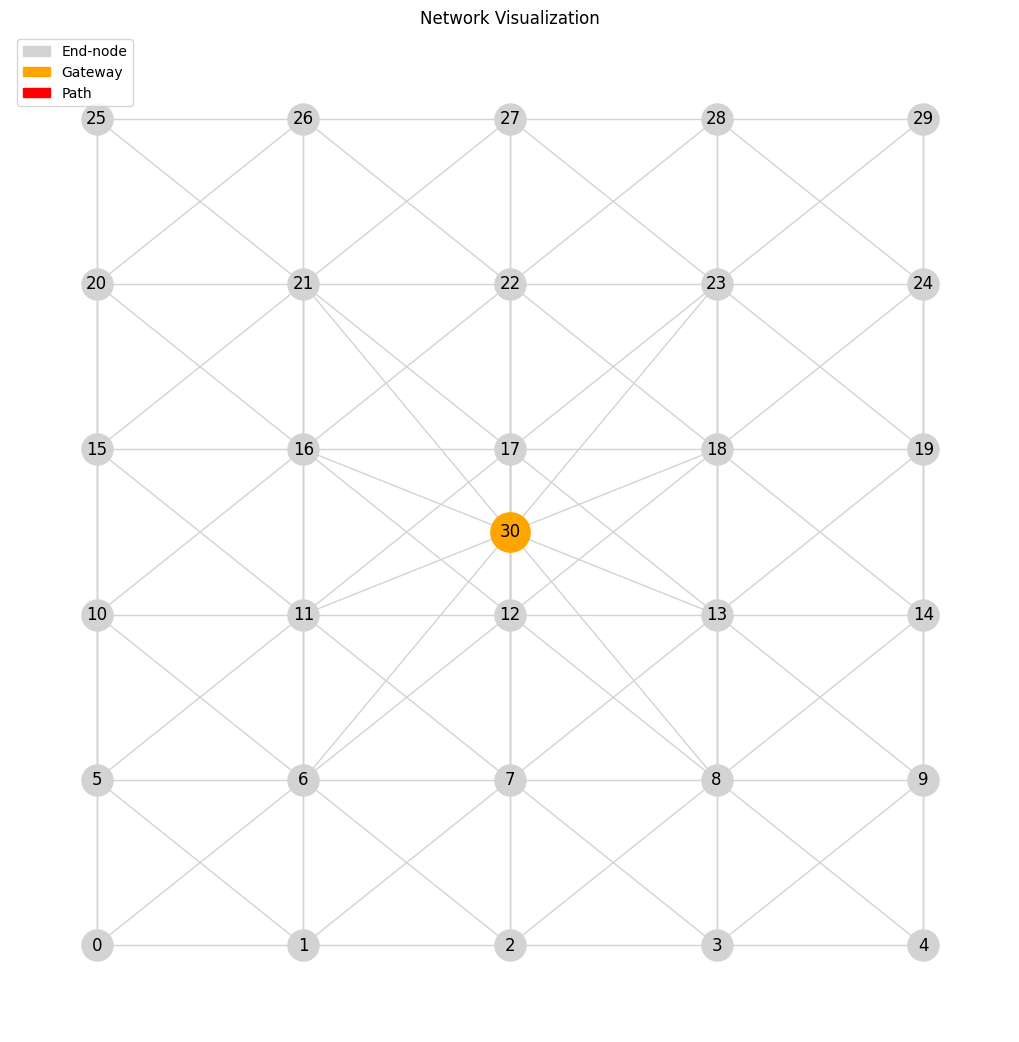

In [12]:
# Initialize the simulation instance
simulation = GreedyNetwork(
                                    graph= G,
                                    node_positions= node_positions,
                                    num_nodes=num_nodes,
                                    communication_radius=communication_radius,
                                    area_size=area_size,
                                    gateway_node=gateway_node,
                                    timeout=timeout,
                                    eps=eps,
                                    lambda_rate = lambda_rate, 
                                    vulnerable_time = vulnerable_time)
simulation.__visualize_network__()

Running simulations with default routing...


Running simulations with dynamic routing...
0.017802953720092773


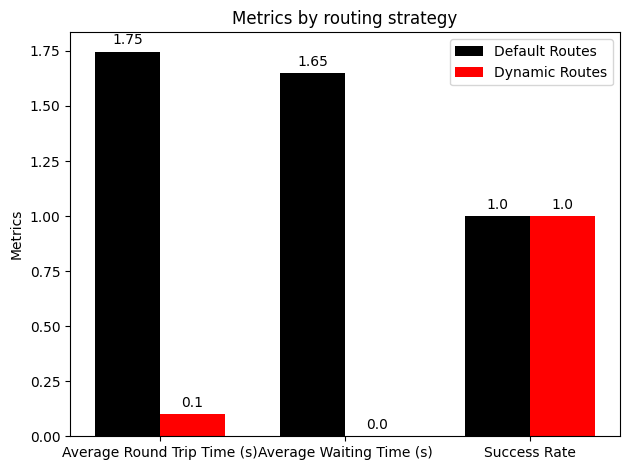

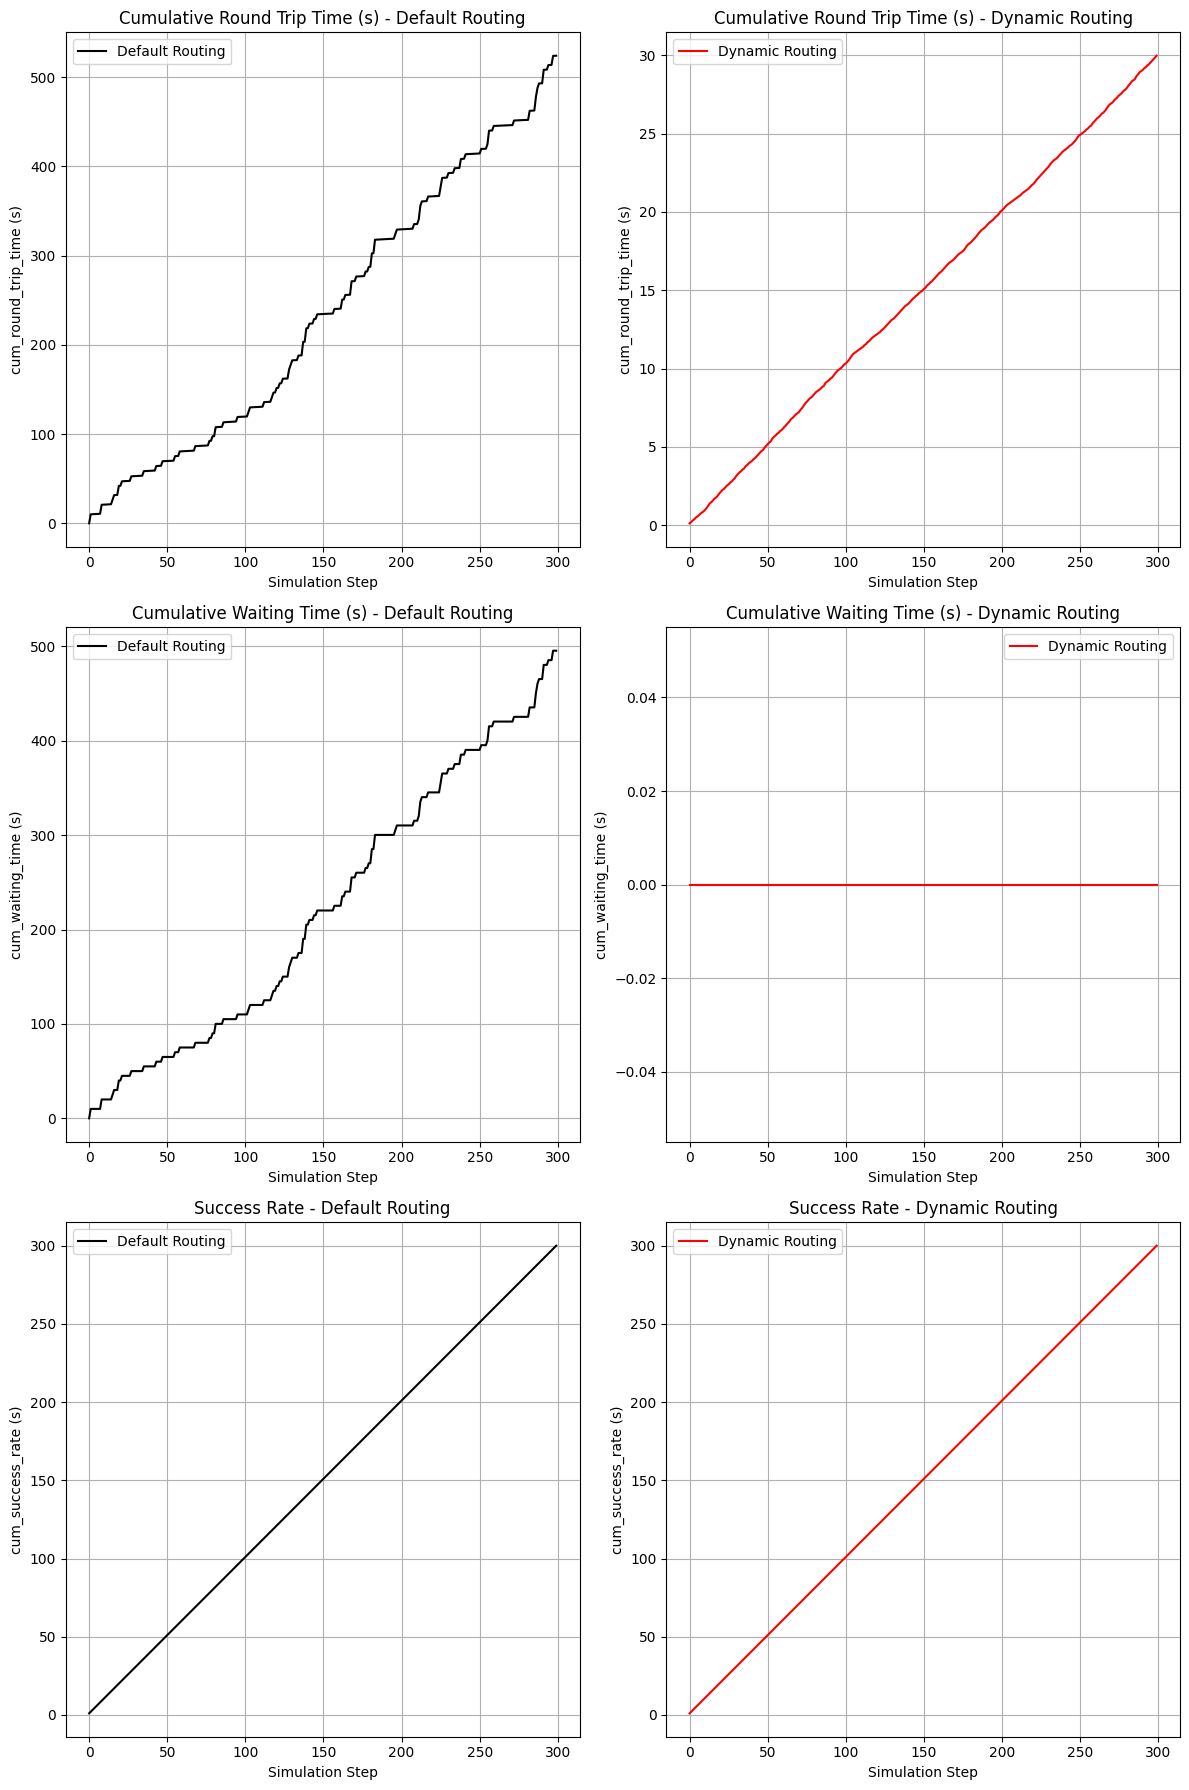

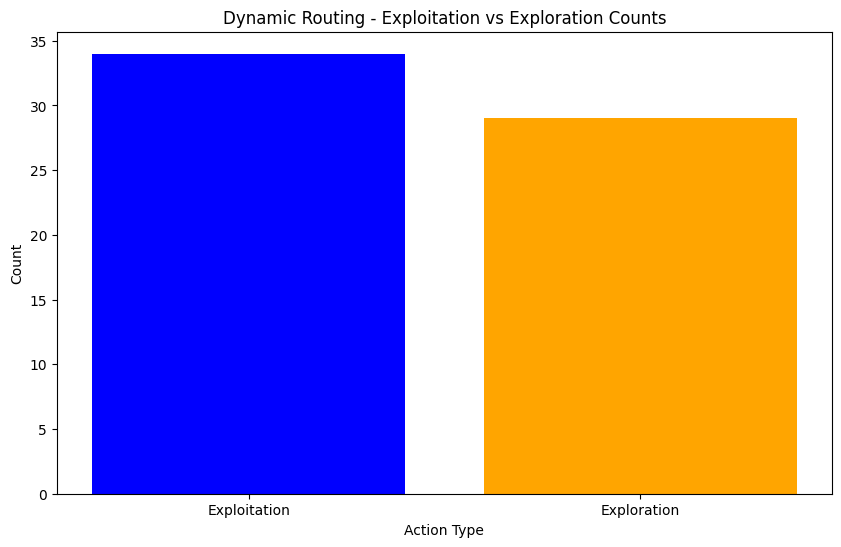

In [13]:
# Run the comparison test and plot the results
compare_routing_strategies(simulation=simulation, n_simulations=n_simulations,verbose=False)

## Partial Connected Graph - greedy strategy

In [14]:
# # Initialize the simulation parameters
# num_nodes = 30
communication_radius = 70
# area_size = (300, 300)
# gateway_node = num_nodes
# n_simulations = 300
# timeout=5 
# eps=0.4
# lambda_rate = 5.5
# vulnerable_time = 36.6*10**(-3)

In [15]:
G,node_positions  = generate_grid_network(num_nodes, communication_radius, area_size)

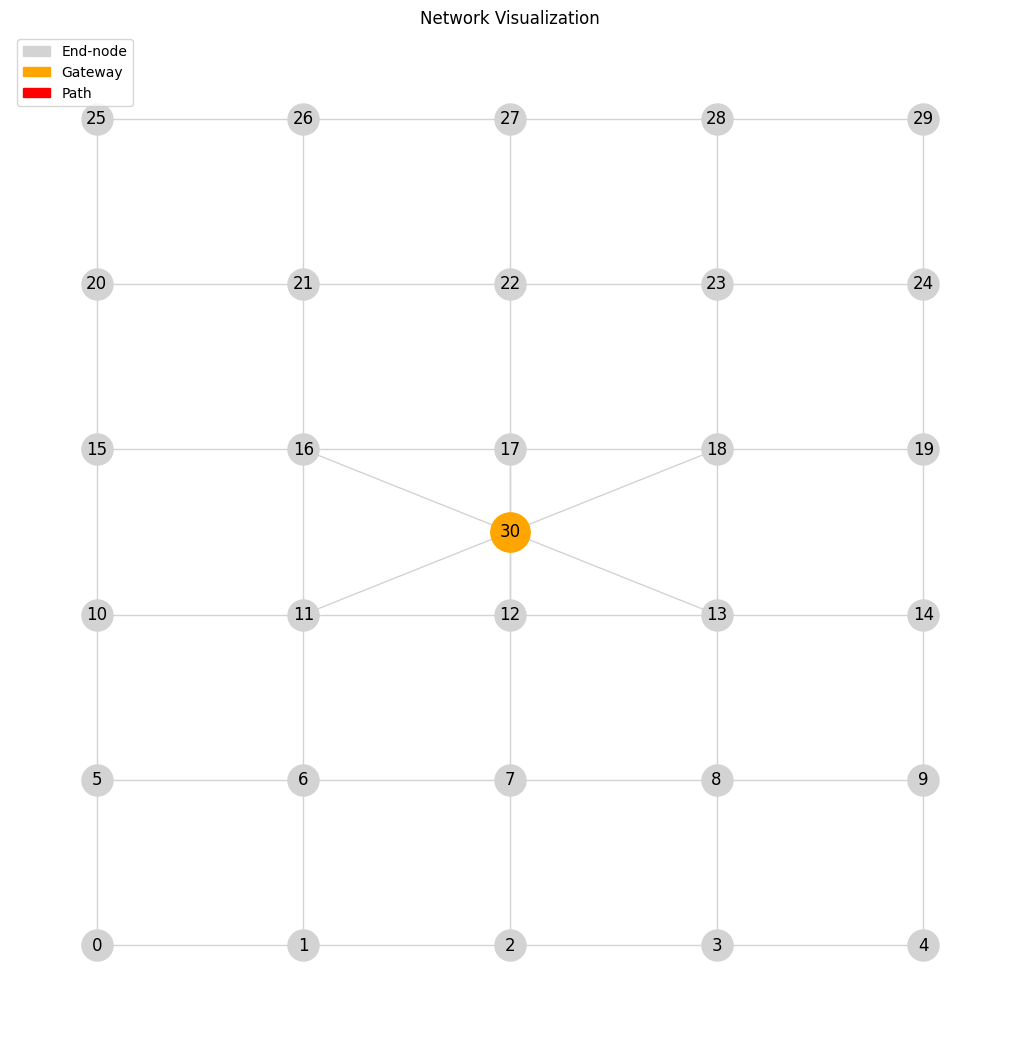

In [16]:
# Initialize the simulation instance
simulation = GreedyNetwork(
                                    graph= G,
                                    node_positions = node_positions,
                                    num_nodes=num_nodes,
                                    communication_radius=communication_radius,
                                    area_size=area_size,
                                    gateway_node=gateway_node,
                                    timeout=timeout,
                                    eps=eps,
                                    lambda_rate = lambda_rate, 
                                    vulnerable_time = vulnerable_time)
simulation.__visualize_network__()

Running simulations with default routing...
Running simulations with dynamic routing...
250.33166885375977


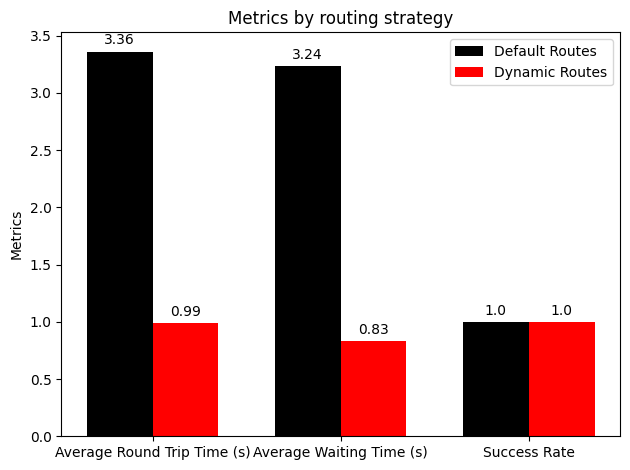

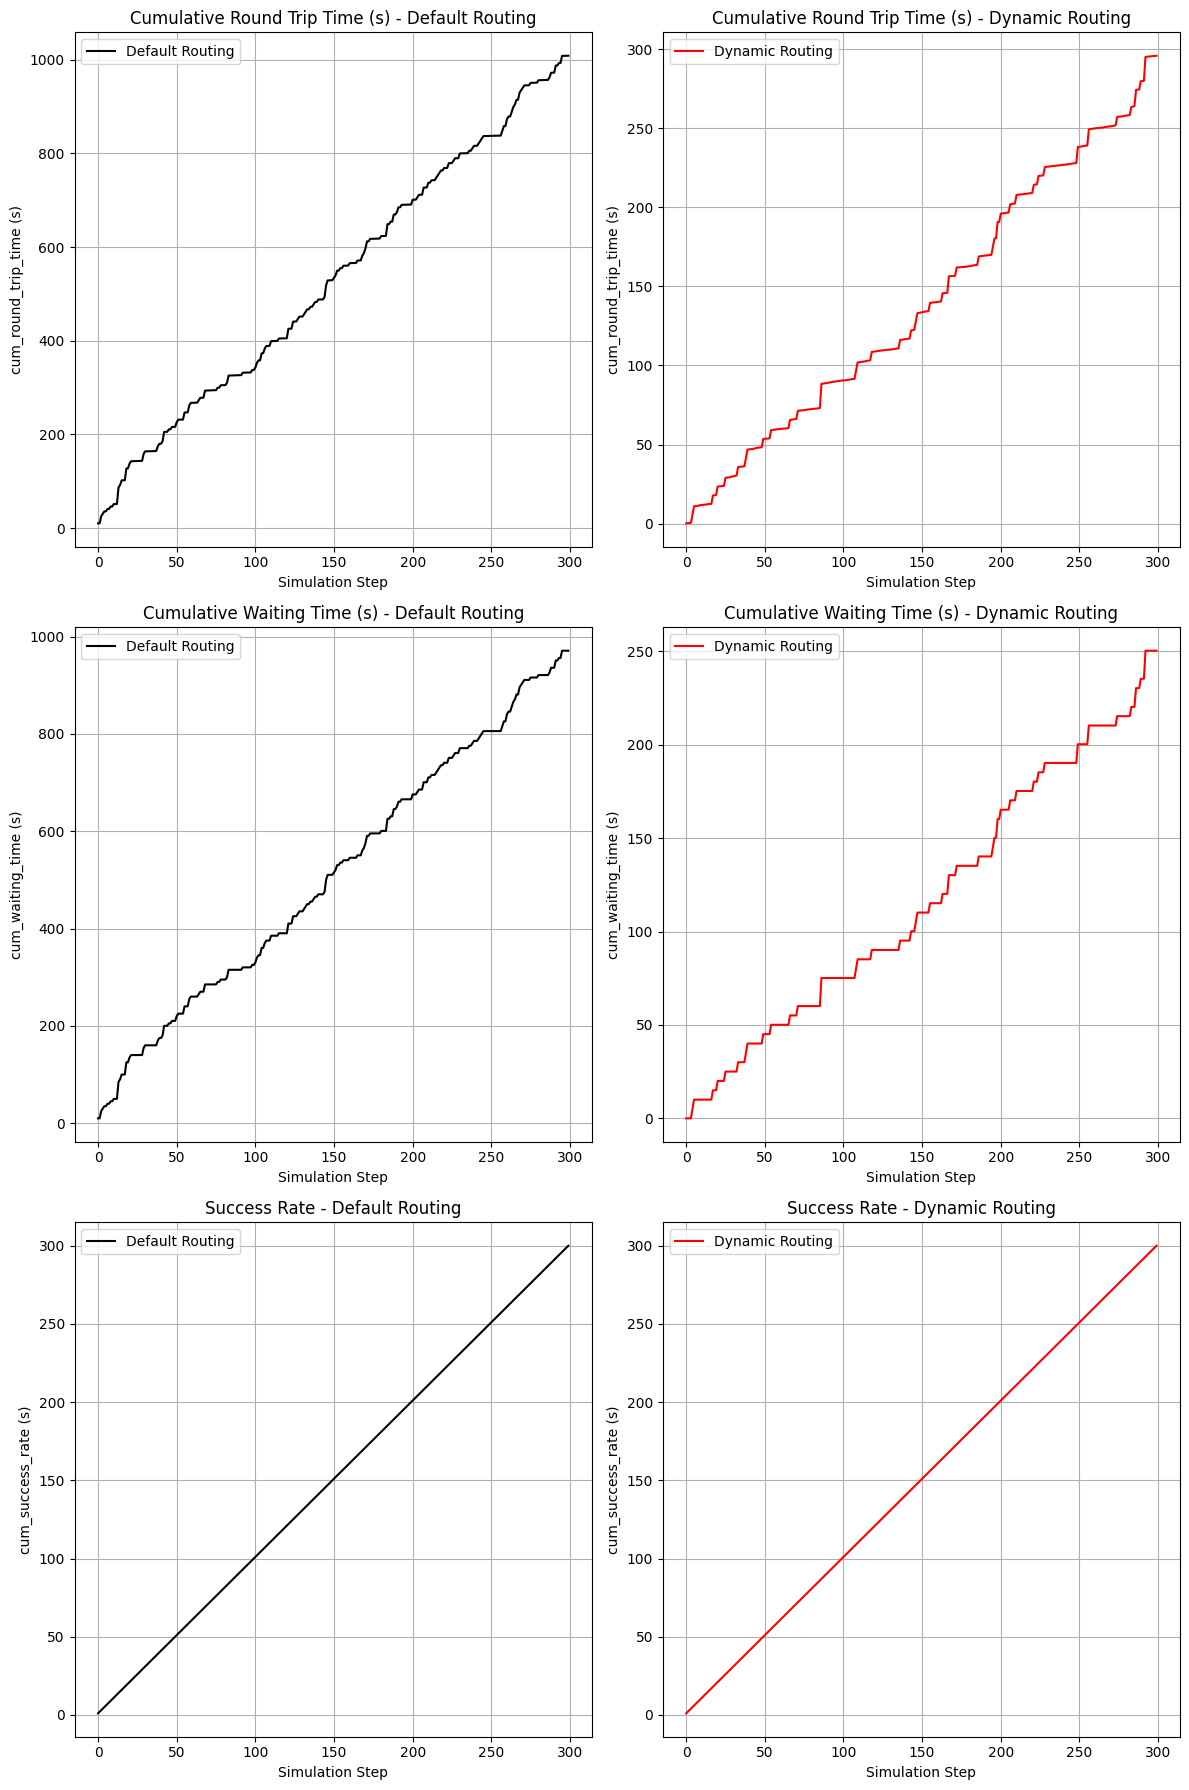

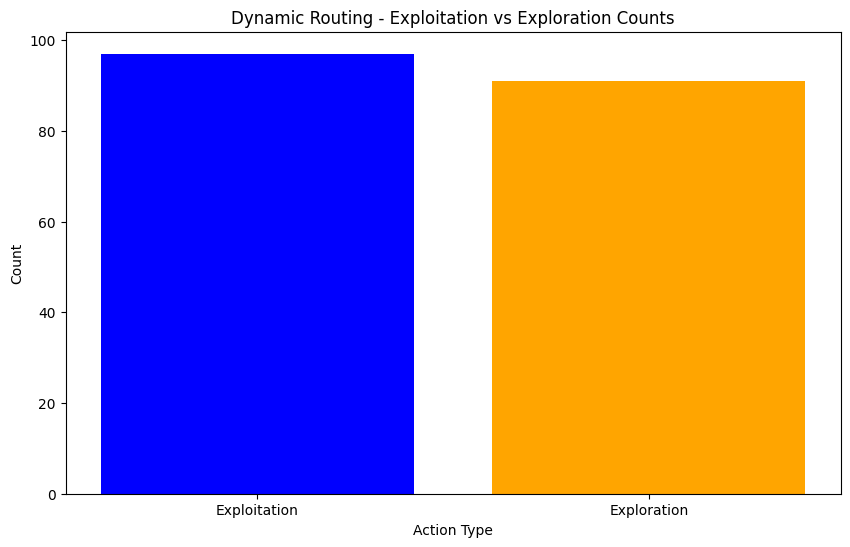

In [17]:
# Run the comparison test and plot the results
compare_routing_strategies(simulation=simulation, n_simulations=n_simulations,verbose=False)

## Random Network - greedy strategy

In [18]:
# # Initialize the simulation parameters
# num_nodes = 30
# communication_radius = 70
# area_size = (300, 300)
# gateway_node = num_nodes
# n_simulations = 300
# timeout=5 
# eps=0.4
# lambda_rate = 5.5
# vulnerable_time = 36.6*10**(-3)

In [19]:
G,node_positions  = generate_rand_network(num_nodes, communication_radius, area_size,gateway_node)

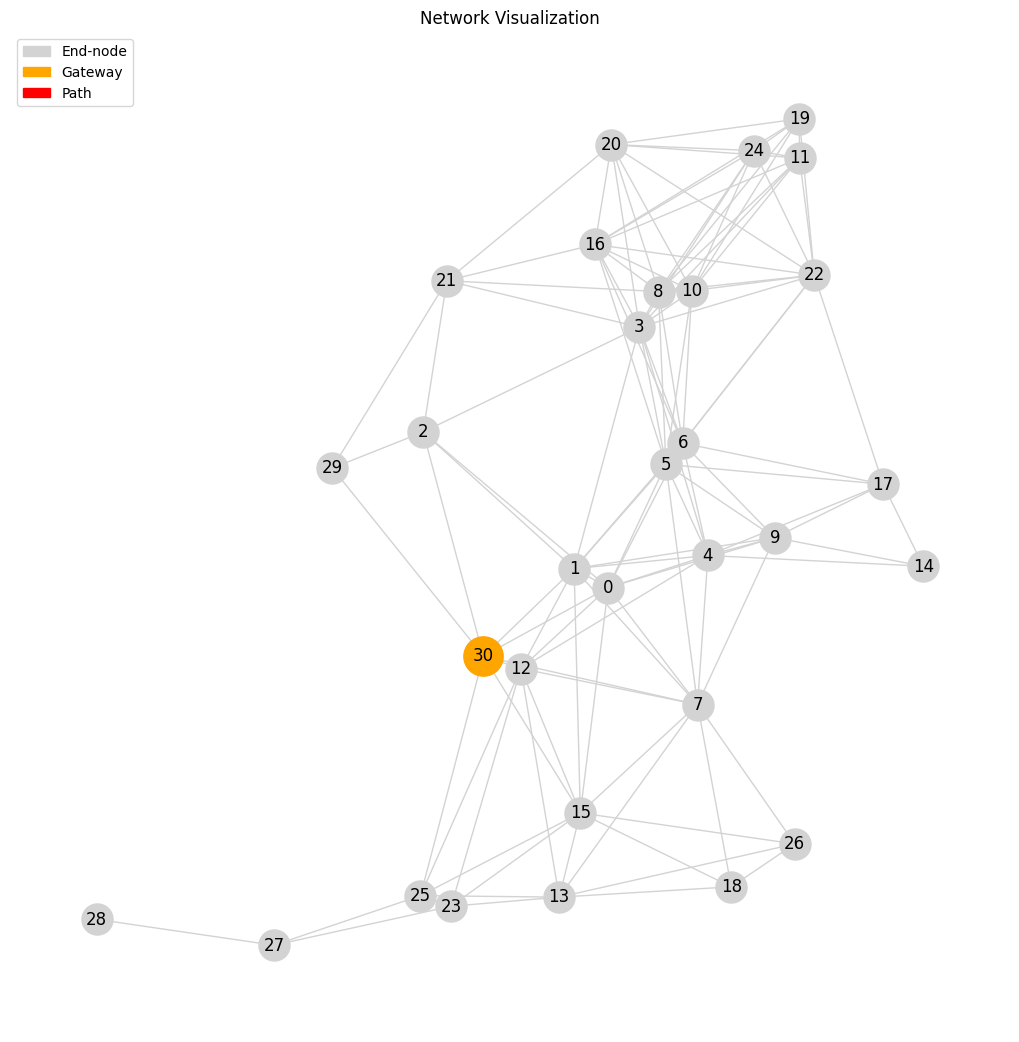

In [20]:
# Initialize the simulation instance
simulation = GreedyNetwork(
                                    graph= G,
                                    node_positions= node_positions,
                                    num_nodes=num_nodes,
                                    communication_radius=communication_radius,
                                    area_size=area_size,
                                    gateway_node=gateway_node,
                                    timeout=timeout,
                                    eps=eps,
                                    lambda_rate = lambda_rate, 
                                    vulnerable_time = vulnerable_time
                                    )
simulation.__visualize_network__()

Running simulations with default routing...


Running simulations with dynamic routing...
60.08508324623108


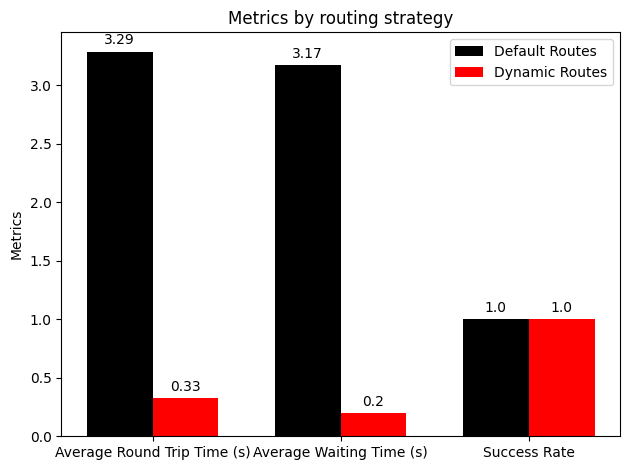

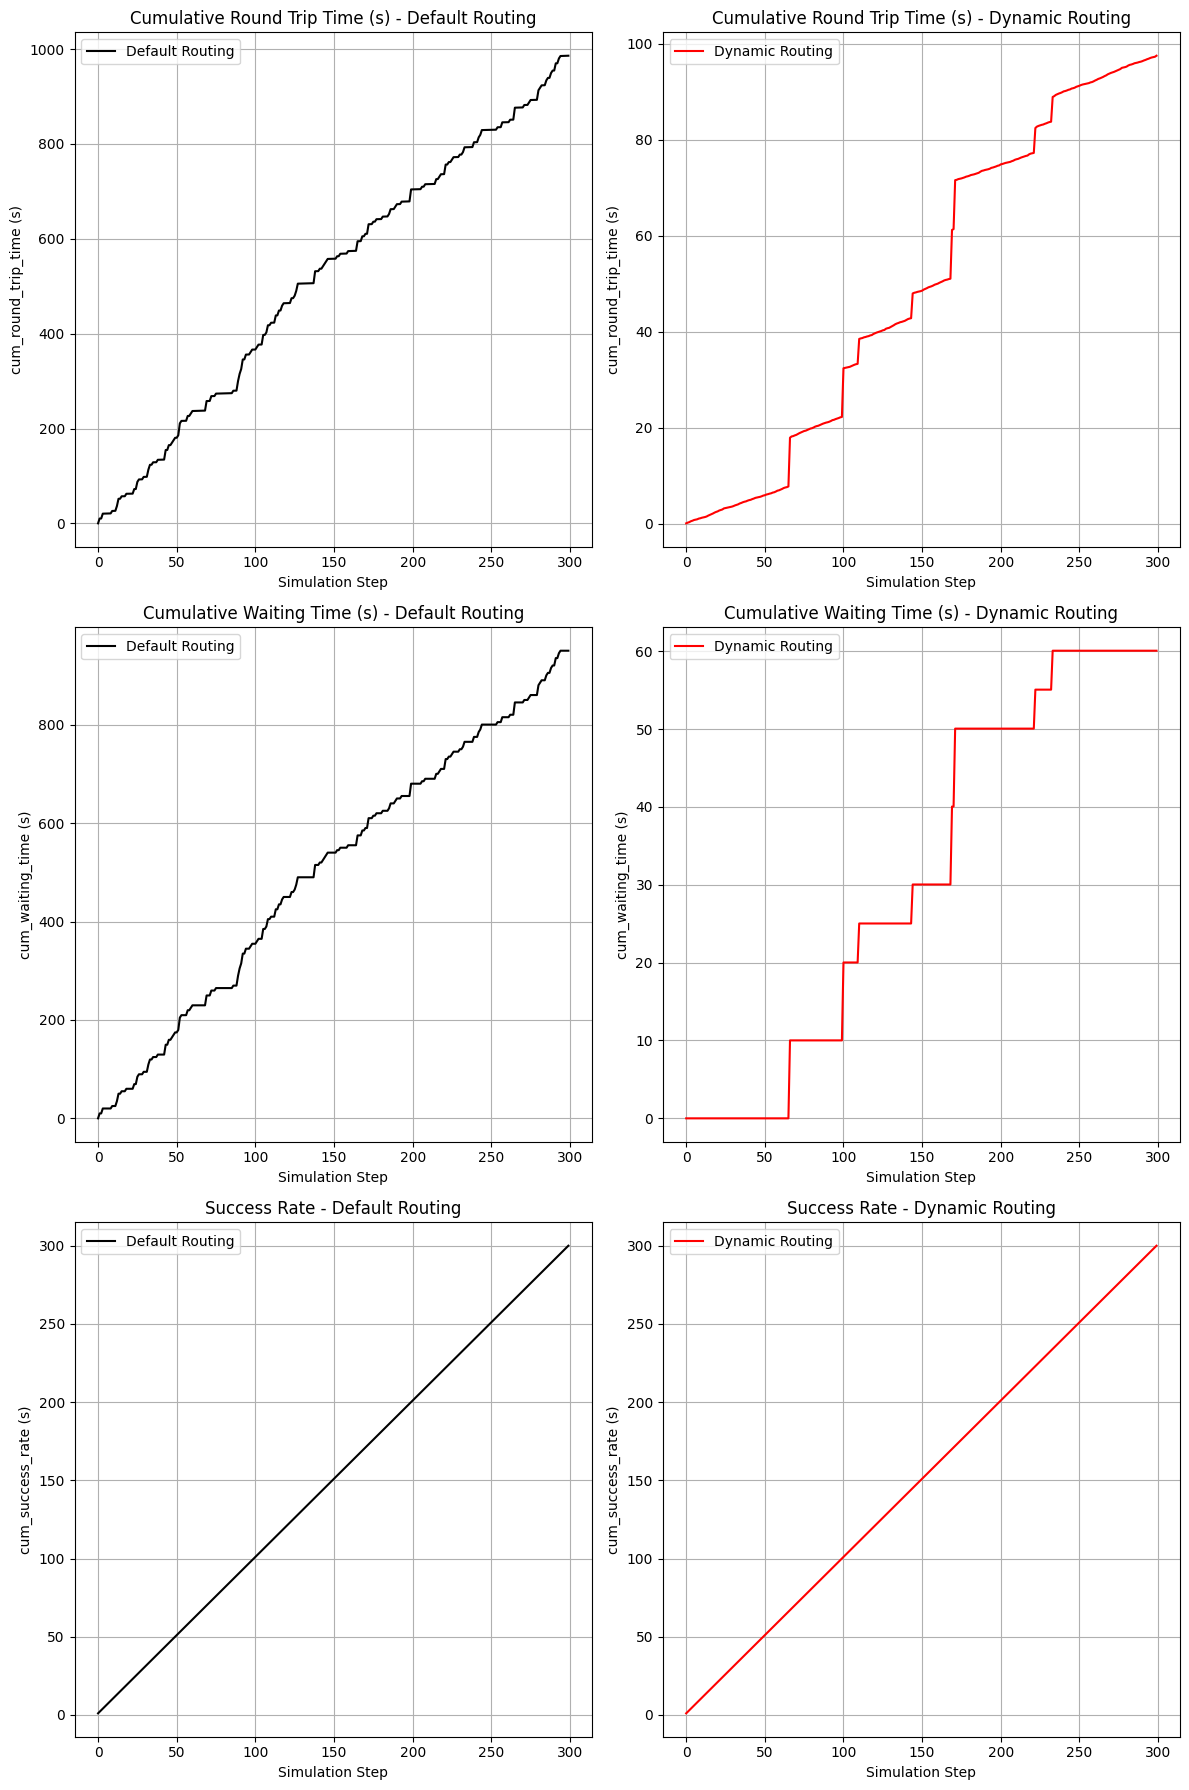

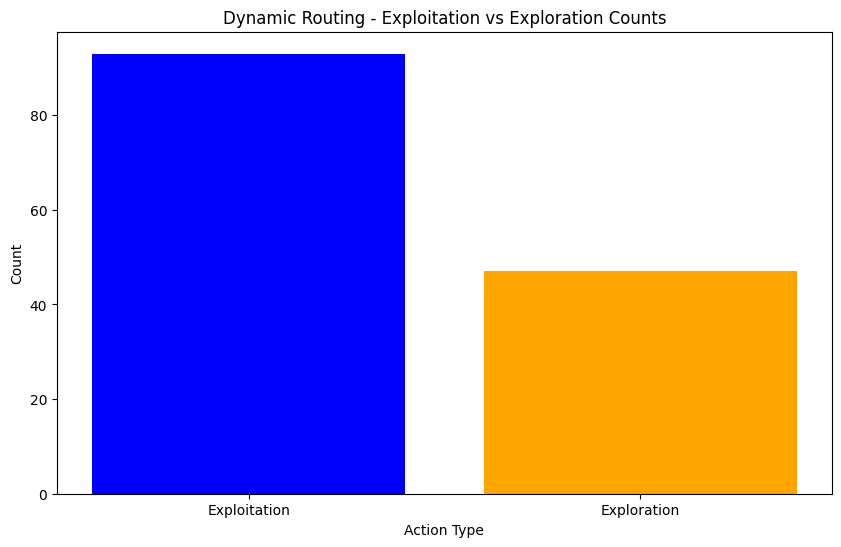

In [21]:
# Run the comparison test and plot the results
compare_routing_strategies(simulation=simulation, n_simulations=n_simulations,verbose=False)

### Learning Network (Local Knwoledge based on Acks)- grid network 

In [22]:
# # Initialize the simulation parameters
# num_nodes = 30
# communication_radius = 70
# area_size = (300, 300)
# gateway_node = num_nodes
# n_simulations = 300
# timeout=5 
# eps=0.4
# lambda_rate = 5.5
# vulnerable_time = 36.6*10**(-3)

In [23]:
G,node_positions  = generate_grid_network(num_nodes, communication_radius, area_size)

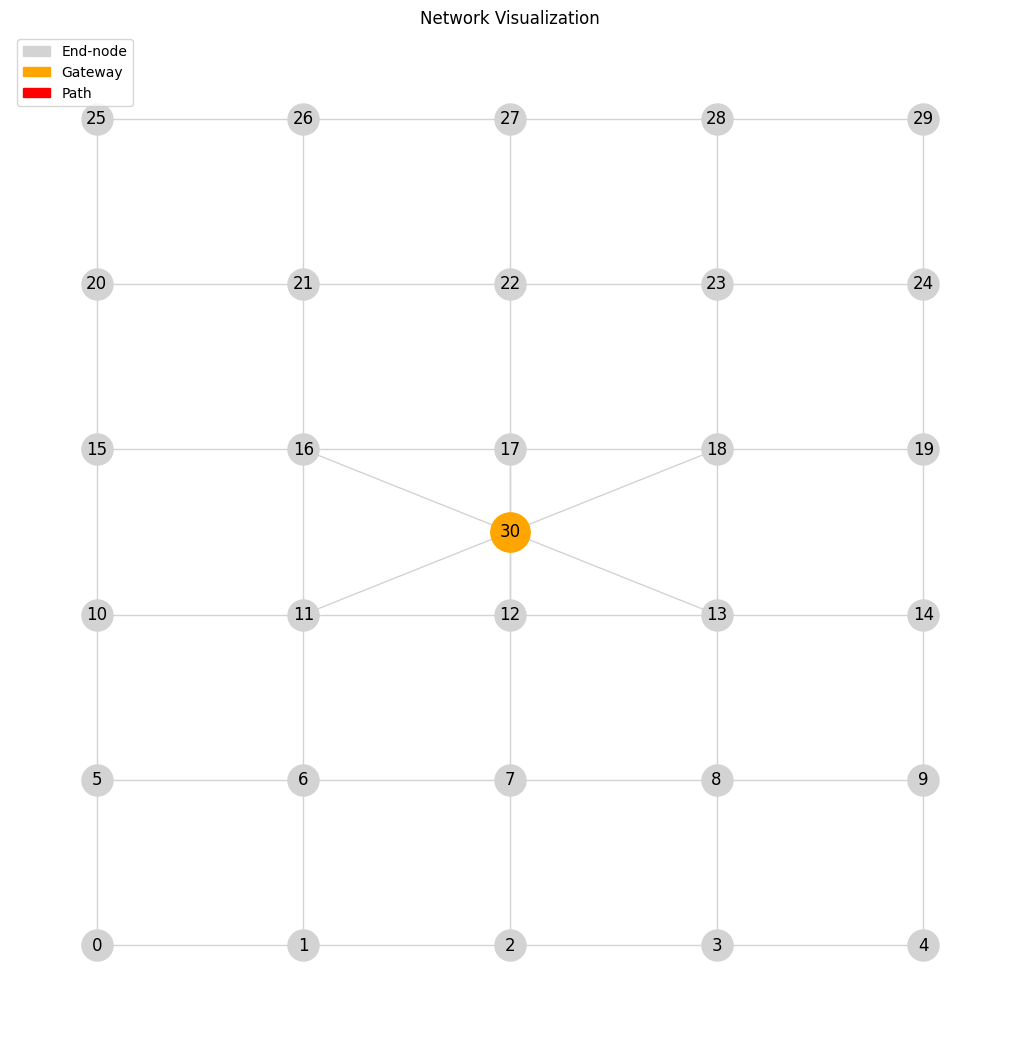

In [24]:
# Initialize the simulation instance
simulation = UCBNetwork(
                                    graph= G,
                                    node_positions= node_positions,
                                    num_nodes=num_nodes,
                                    communication_radius=communication_radius,
                                    area_size=area_size,
                                    gateway_node=gateway_node,
                                    timeout=timeout,
                                    eps=eps,
                                    lambda_rate = lambda_rate, 
                                    vulnerable_time = vulnerable_time
                                    )
simulation.__visualize_network__()

In [25]:
# Run the comparison test and plot the results
ucb_compare_routing_strategies(simulation=simulation, n_simulations=n_simulations,verbose=False)

Running simulations with dynamic routing...


KeyboardInterrupt: 

### Learning Network (Local Knwoledge based on Acks)- random generated network 

In [ ]:
# # Initialize the simulation parameters
# num_nodes = 30
# communication_radius = 70
# area_size = (300, 300)
# gateway_node = num_nodes
# n_simulations = 300
# timeout=5 
# eps=0.4
# lambda_rate = 5.5
# vulnerable_time = 36.6*10**(-3)

In [ ]:
G,node_positions  = generate_rand_network(num_nodes, communication_radius, area_size, gateway_node)

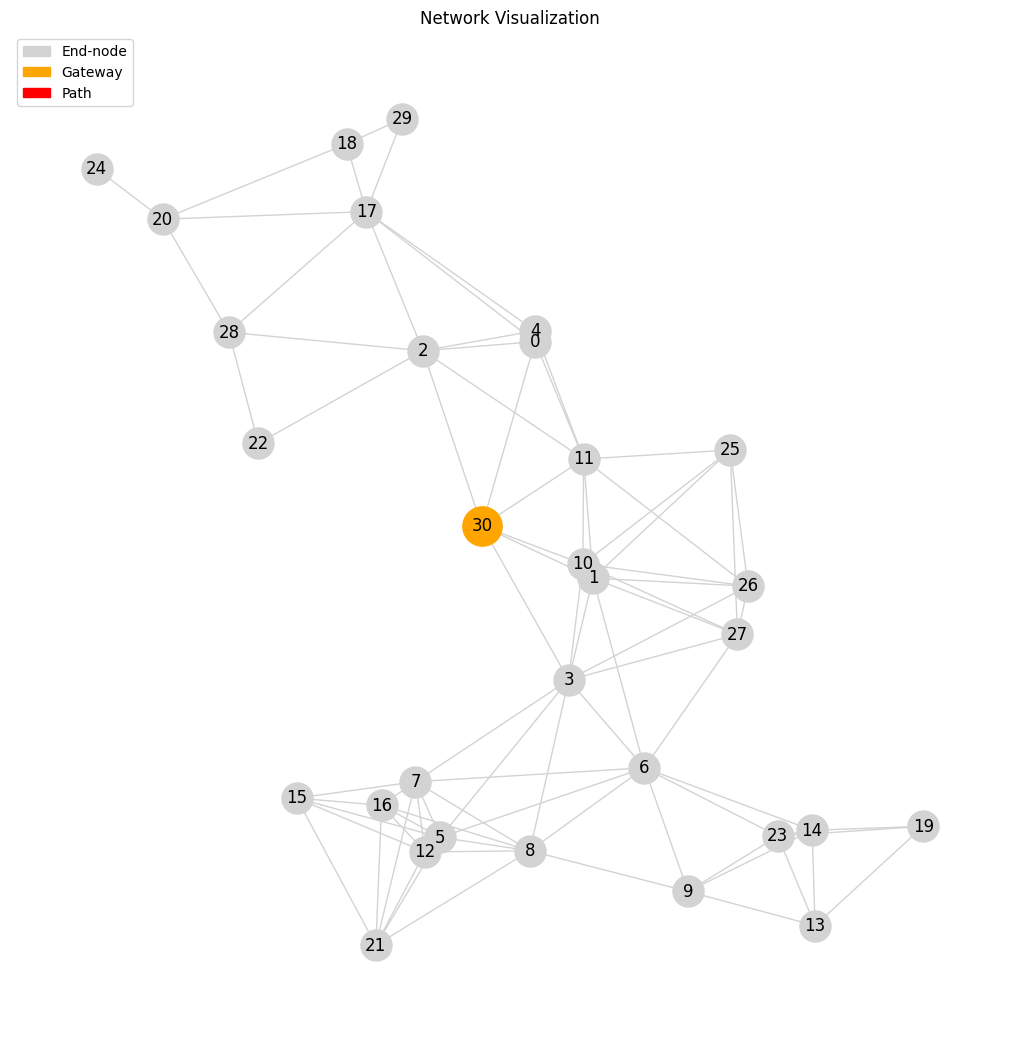

In [ ]:
# Initialize the simulation instance
simulation = UCBNetwork(
                                    graph= G,
                                    node_positions= node_positions,
                                    num_nodes=num_nodes,
                                    communication_radius=communication_radius,
                                    area_size=area_size,
                                    gateway_node=gateway_node,
                                    timeout=timeout,
                                    eps=eps,
                                    lambda_rate = lambda_rate, 
                                    vulnerable_time = vulnerable_time
                                    )
simulation.__visualize_network__()

Running simulations with dynamic routing...


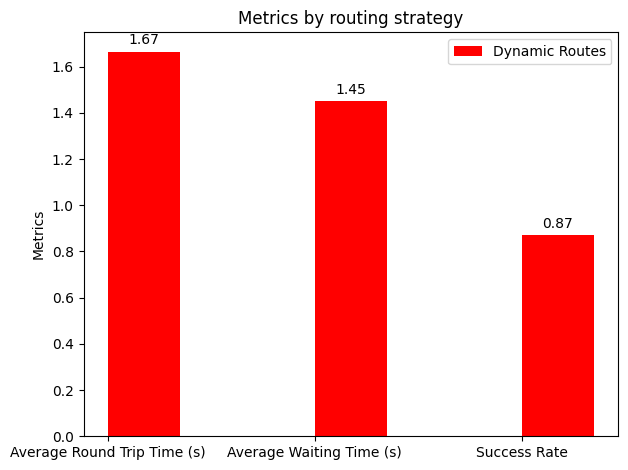

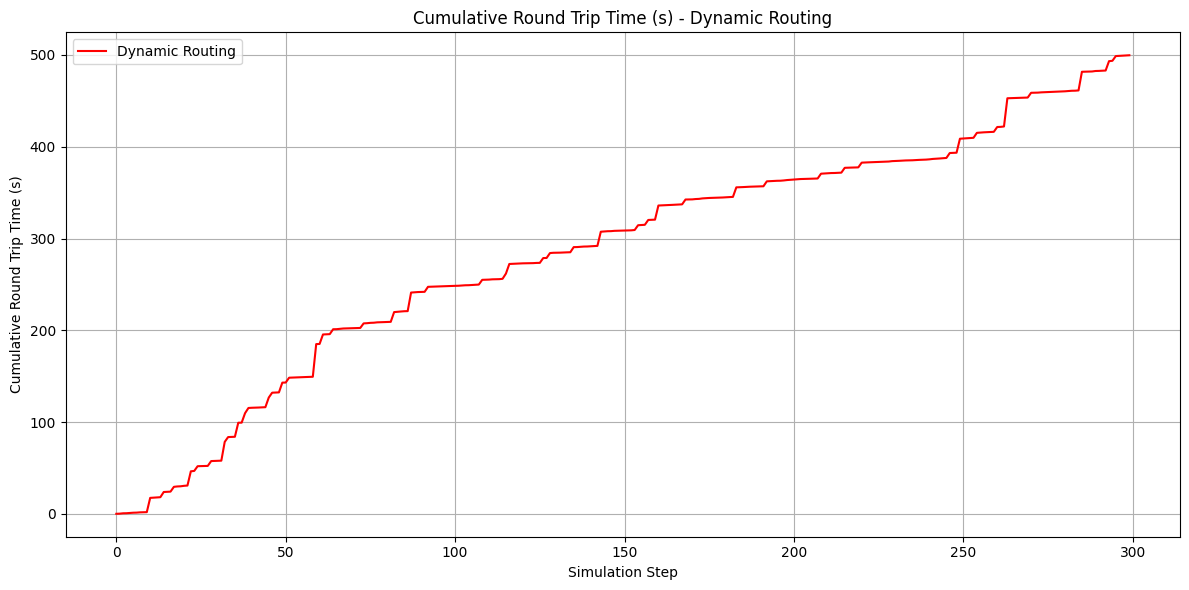

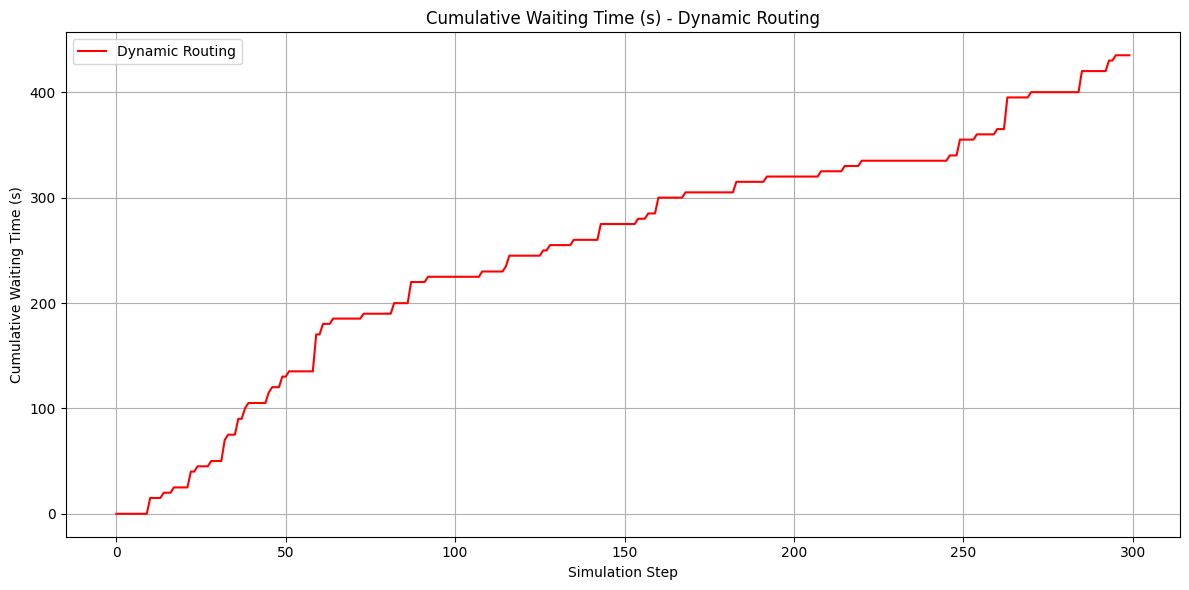

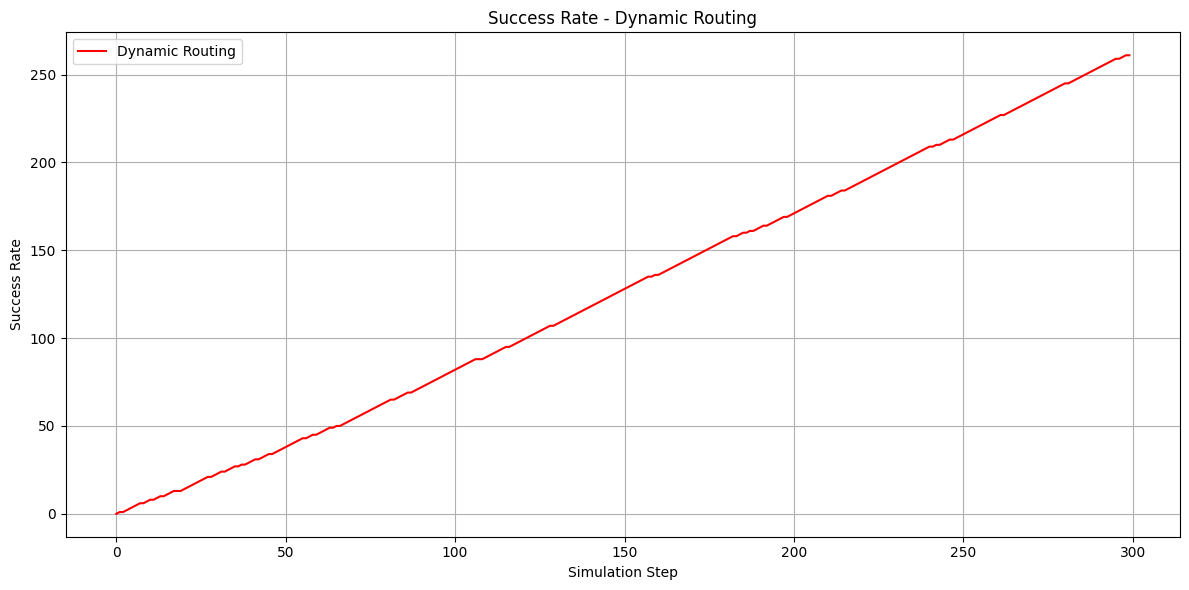

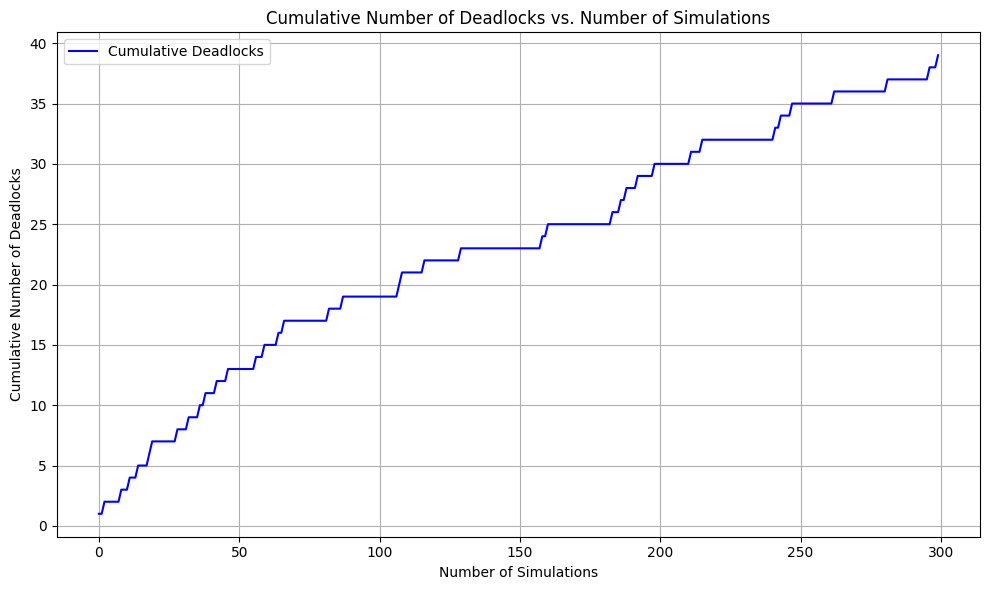

In [ ]:
# Run the comparison test and plot the results
ucb_compare_routing_strategies(simulation=simulation, n_simulations=n_simulations,verbose=False)

### Epsilon Comparison

In [ ]:
epsilon_values = [0.3, 0.5, 0.7, 0.9]

In [ ]:
# # Initialize the simulation parameters
# num_nodes = 30
# communication_radius = 70
# area_size = (300, 300)
# gateway_node = num_nodes
# n_simulations = 300
# timeout=5 
# eps=0.4
# lambda_rate = 5.5
# vulnerable_time = 36.6*10**(-3)

G,node_positions  = generate_rand_network(num_nodes, communication_radius, area_size, gateway_node)

### Naive Routing Adaptation

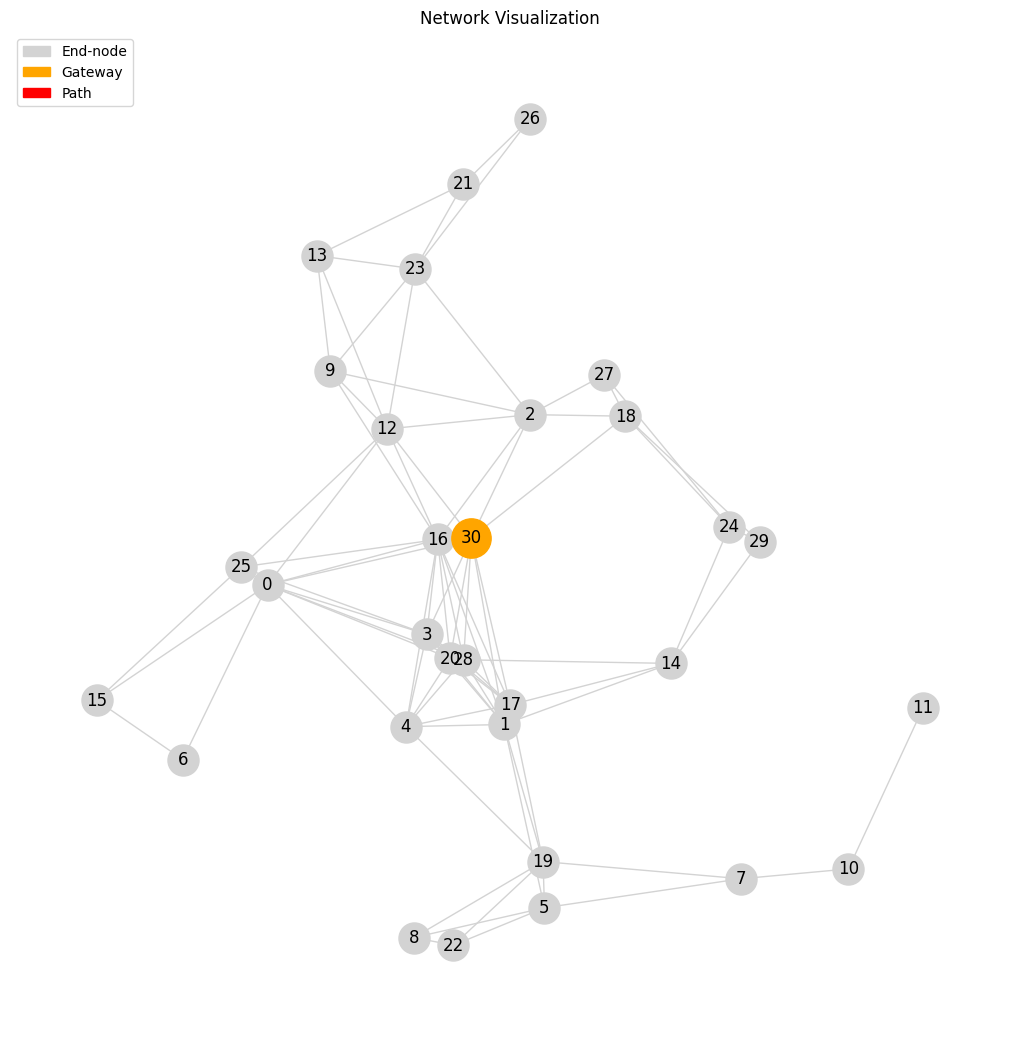

Running simulations with dynamic routing...
Running simulations with dynamic routing...
Running simulations with dynamic routing...
Running simulations with dynamic routing...


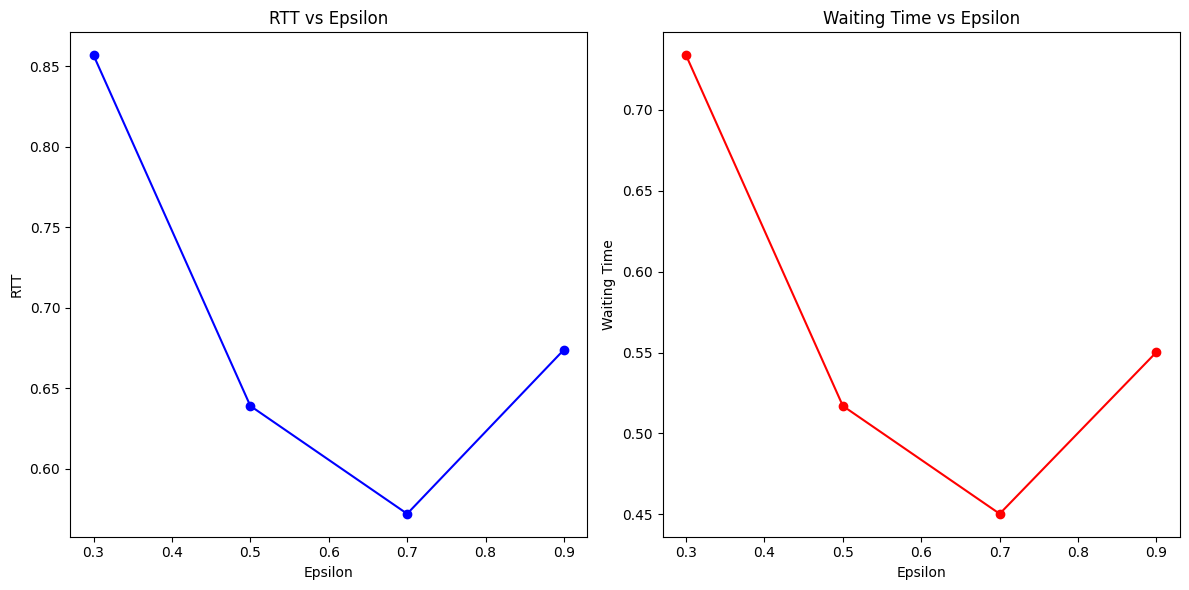

In [ ]:
# Initialize the simulation instance
simulation = GreedyNetwork(
                                    graph= G,
                                    node_positions= node_positions,
                                    num_nodes=num_nodes,
                                    communication_radius=communication_radius,
                                    area_size=area_size,
                                    gateway_node=gateway_node,
                                    timeout=timeout,
                                    eps=eps,
                                    lambda_rate = lambda_rate, 
                                    vulnerable_time = vulnerable_time)
simulation.__visualize_network__()
eps_comparison(epsilon_values, simulation)